In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

if 'path' in locals(): os.chdir(path)
else: os.chdir("../../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/MFI_paper_June24/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 12})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

plt.rcParams['xtick.minor.visible'] = False
plt.rcParams['ytick.minor.visible'] = False

# load ref surface 40M
os.chdir(path_manustript + "Figure1B")
FES_ref = MFI.load_pkl("AD_ref_fes")

The path is: /home/ucecabj/Desktop/MFI_git


### Analyse Alanine Dipeptide simulation with MFI

In [2]:
###--- Analyse the data with MFI
#Read the HILLS and Colvar data
os.chdir(path_manustript + "Figure1B")
HILLS=MFI.load_HILLS_2D(hills_name="HILLS40")
[position_x, position_y] = MFI.load_position_2D(position_name="position40")

#Compute the time-independent mean force and free energy surface
NH=10000
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, error_pace=int(NH/2000), WellTempered=1, nhills=NH, periodic = [1,1], ref_fes=FES_ref, use_weighted_st_dev=False)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results

# #integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=[-np.pi, -np.pi], max_grid=[np.pi, np.pi], periodic=[1,1])

#Find Absolute deviation
AD = abs(FES_ref - FES) 
ADc = AD * cutoff
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("\nAAD =" ,round(AAD,2) , "   |    AAD_cut =", round(AADc,2))

# rename results for later use
[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, ADc, cutoff, time_history, ofe_history, aad_history, volume_history]

|**************************************************| 100% | Average Mean Force Error: 4.963
AAD = 2.32    |    AAD_cut = 0.79


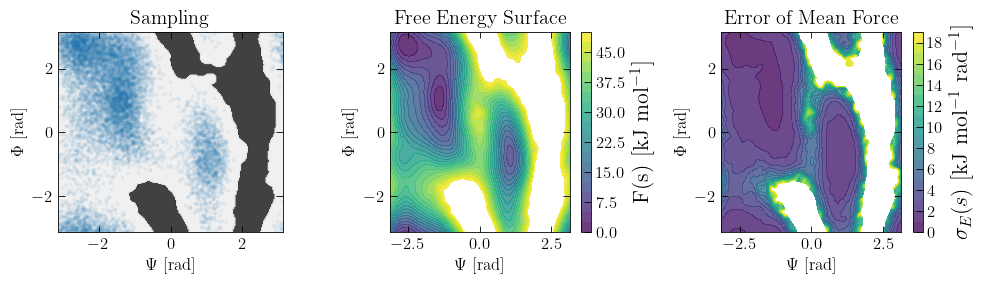

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(10,3))

axs[0].contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
axs[0].scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05, s=4);
axs[0].set_ylabel('$\Phi$ [rad]'); axs[0].set_xlabel('$\Psi$ [rad]'); axs[0].set_title("Sampling") ; axs[0].set_xlim(np.min(X),np.max(X)); axs[0].set_ylim(np.min(Y),np.max(Y))

cp = axs[1].contourf(X, Y, FES_1, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[1]); cbar.set_label("F(s) [kJ mol$^{-1}$]",fontsize=16); 
axs[1].set_ylabel('$\Phi$ [rad]'); axs[1].set_xlabel('$\Psi$ [rad]'); axs[1].set_title("Free Energy Surface"); axs[1].set_xlim(np.min(X),np.max(X)); axs[1].set_ylim(np.min(Y),np.max(Y))

cp = axs[2].contourf(X, Y, np.where(cutoff_1 > 0.5, ofe_1, np.nan), levels=np.arange(0, 20, 1), cmap='viridis', antialiased=False, alpha=0.8);
cbar = plt.colorbar(cp, ax=axs[2]); cbar.set_label("$\sigma_E(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]",fontsize=16)
axs[2].set_ylabel('$\Phi$ [rad]'); axs[2].set_xlabel('$\Psi$ [rad]'); axs[2].set_title("Error of Mean Force"); axs[2].set_xlim(np.min(X),np.max(X)); axs[2].set_ylim(np.min(Y),np.max(Y))

fig.tight_layout(); plt.show()

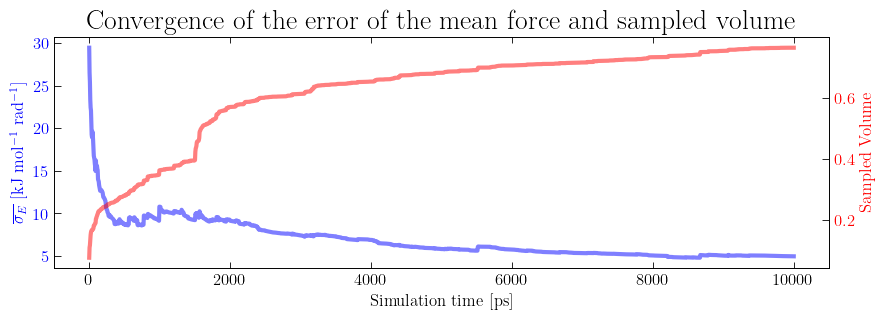

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(10,3))
axs.plot( [time for time in time_history[1:]], (ofe_history[1:NH]),color='blue',alpha=0.5,linewidth=3);
axs.set_ylabel('$\overline{\sigma_E}$ [kJ mol$^{-1}$ rad$^{-1}$]', color='blue'); axs.set_xlabel('Simulation time [ps]'); axs.tick_params(axis ='y', labelcolor = 'blue')

ax2 = axs.twinx()
ax2.plot( [time for time in time_history[1:]], volume_history[1:NH],color='red',alpha=0.5,linewidth=3);
ax2.set_xlabel('Simulation steps'); ax2.set_ylabel('Sampled Volume',color='red'); ax2.set_title('Convergence of the error of the mean force and sampled volume', fontsize=20); ax2.tick_params(axis ='y', labelcolor = 'red')


### Plot results after 700, 2200 and 9400 Hills

|**************************************************| 100% | Average Mean Force Error: 8.615

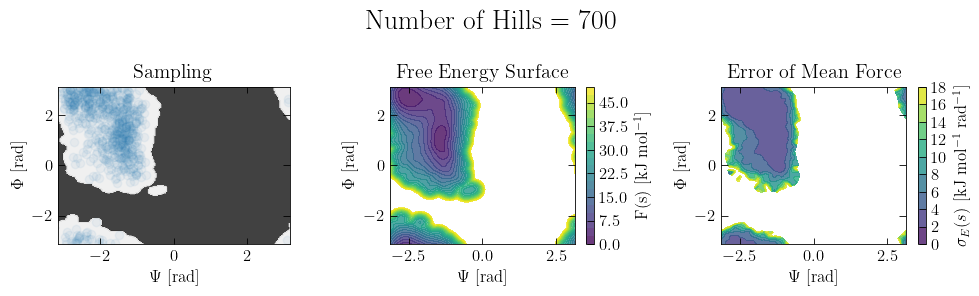

|**************************************************| 100% | Average Mean Force Error: 8.711

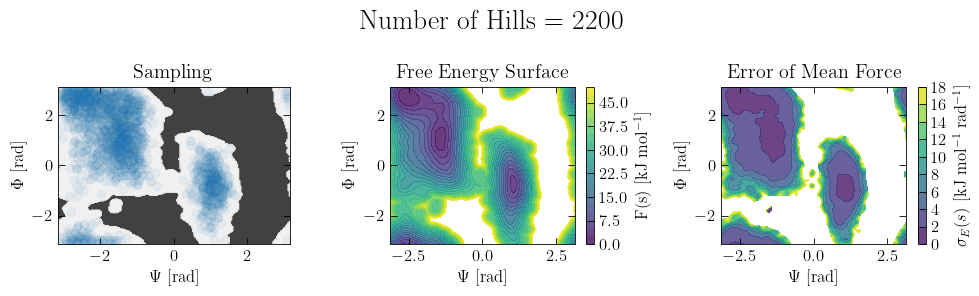

|**************************************************| 100% | Average Mean Force Error: 5.075

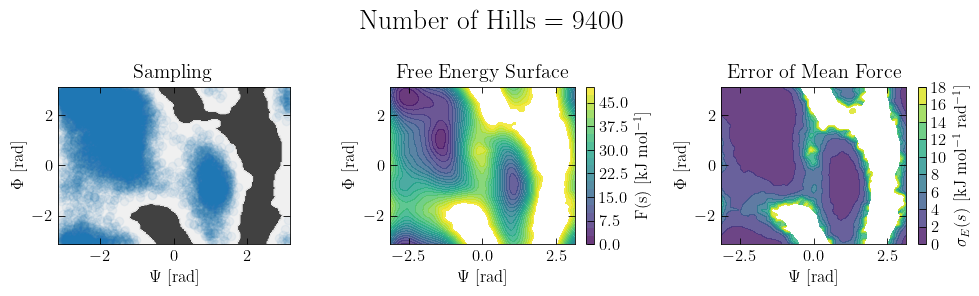

In [27]:
NH_list = [700, 2200, 9400]

for NH in NH_list:
    #Compute the time-independent mean force
    results_temp = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = [0.1,0.1], kT = 2.49, error_pace = -3, nhills=NH, periodic = [1,1],use_weighted_st_dev=False)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results_temp

    # #integration with the FFT method
    [X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-np.pi, -np.pi)), max_grid=np.array((np.pi, np.pi)), periodic = np.array((1,1)))

    fig, axs = plt.subplots(1, 3, figsize=(10,3))
    plt.suptitle("Number of Hills = " + str(NH), fontsize=20)
    
    axs[0].contourf(X, Y, cutoff, cmap='gray', antialiased=False, alpha=0.8);
    axs[0].scatter(HILLS[0:NH,1],HILLS[0:NH,2],alpha=0.05);
    axs[0].set_ylabel('$\Phi$ [rad]'); axs[0].set_xlabel('$\Psi$ [rad]'); axs[0].set_title("Sampling"); axs[0].set_xlim(np.min(X),np.max(X)); axs[0].set_ylim(np.min(Y),np.max(Y))
    
    cp = axs[1].contourf(X, Y, FES, levels=np.arange(0, 51, 2.5), cmap='viridis', antialiased=False, alpha=0.8);
    cbar = plt.colorbar(cp, ax=axs[1]); cbar.set_label("F(s) [kJ mol$^{-1}$]"); 
    axs[1].set_ylabel('$\Phi$ [rad]'); axs[1].set_xlabel('$\Psi$ [rad]'); axs[1].set_title("Free Energy Surface"); axs[1].set_xlim(np.min(X),np.max(X)); axs[1].set_ylim(np.min(Y),np.max(Y))

    ofe[cutoff==0]=np.NaN
    cp = axs[2].contourf(X, Y, np.where(cutoff > 0.5, ofe, np.nan), levels=np.arange(0, 20, 2), cmap='viridis', antialiased=False, alpha=0.8);
    cbar = plt.colorbar(cp, ax=axs[2]); cbar.set_label("$\sigma_E(s)$ [kJ {mol}$^{-1}$ {rad}$^{-1}$]"); 
    axs[2].set_ylabel('$\Phi$ [rad]'); axs[2].set_xlabel('$\Psi$ [rad]'); axs[2].set_title("Error of Mean Force"); axs[2].set_xlim(np.min(X),np.max(X)); axs[2].set_ylim(np.min(Y),np.max(Y))

    fig.tight_layout(); plt.show();
    
    if NH == 700:  results_700,  cutoff_700  = results_temp, cutoff
    if NH == 2200: results_2200, cutoff_2200 = results_temp, cutoff
    if NH == 9400: results_9400, cutoff_9400 = results_temp, cutoff

### Save data for figure 1 plot

In [31]:
###--- Save data for figure 1 plot
MFI.save_pkl([X, Y, FES_1, ofe_1, cutoff_1, time_history_1, ofe_history_1, volume_history_1, HILLS, cutoff_700, cutoff_2200, cutoff_9400], path_manustript +"Figure1/" + "data_figure_1B.pkl")
MFI.save_pkl([time_history_1, ofe_history_1, aad_history_1, volume_history_1], path_manustript +"Figure4/" + "data_figure_4_1B.pkl")